In [1]:
!pip install -q transformers scikit-learn matplotlib tqdm

In [2]:
! pip install -q torch torchvision torchaudio torchcodec --index-url https://download.pytorch.org/whl/cu126

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.5 MB/s eta 0:00:0000:0100:01


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2.8.0+cu126
True
Tesla T4


In [5]:
import os
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchaudio")

import torch
import torchaudio
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from transformers import WhisperModel
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
AUDIO_DIR = "/kaggle/input/hs-dataset/Heart_sound_dataset/HS_wav_dataset"
META_JSON = "/kaggle/input/hs-dataset/Heart_sound_dataset/meta_map.json"

SAMPLE_RATE = 2000
MAX_SEC = 30
MAX_LEN = SAMPLE_RATE * MAX_SEC
BATCH_SIZE = 8

In [7]:
class MurmurDataset(Dataset):
    def __init__(self, audio_dir, meta_json,
                 sr=SAMPLE_RATE, max_len=MAX_LEN):
        with open(meta_json, "r") as f:
            self.meta = json.load(f)

        self.audio_dir = audio_dir
        self.files = list(self.meta.keys())
        self.sr = sr
        self.max_len = max_len

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.meta[fname]

        wav, sr = torchaudio.load(
            os.path.join(self.audio_dir, fname)
        )
        wav = wav.mean(0)

        if sr != self.sr:
            wav = torchaudio.functional.resample(wav, sr, self.sr)
        wav = wav / (wav.abs().max() + 1e-6)

        if wav.shape[0] < self.max_len:
            wav = torch.nn.functional.pad(
                wav, (0, self.max_len - wav.shape[0])
            )

        wav = wav[:self.max_len]
        return wav, torch.tensor(label, dtype=torch.long)

In [8]:
dataset = MurmurDataset(AUDIO_DIR, META_JSON,
                         sr=SAMPLE_RATE, max_len=MAX_LEN)

labels = [dataset.meta[f] for f in dataset.files]

train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples:   {len(val_ds)}")

Train samples: 3331
Val samples:   833


In [9]:
class MurmurModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=128,
            hop_length=32,
            n_mels=80,
            f_min=20,
            f_max=800
        )

        self.encoder = WhisperModel.from_pretrained(
            "openai/whisper-small"
        ).encoder

        for p in self.encoder.parameters():
            p.requires_grad = False
            
        hidden = self.encoder.config.hidden_size

        self.attn = nn.Sequential(
            nn.Linear(hidden, 1),
            nn.Softmax(dim=1)
        )
        
        self.temporal = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden,
                nhead=4,
                dim_feedforward=hidden * 2,
                batch_first=True,
                activation="gelu"
            ),
            num_layers=2
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, wav):
        mel = torch.log(self.mel(wav) + 1e-6)

        MAX_FRAMES = 3000
        T = mel.shape[-1]

        if T > MAX_FRAMES:
            mel = mel[..., :MAX_FRAMES]
        else:
            mel = torch.nn.functional.pad(
                mel, (0, MAX_FRAMES - T)
            )

        feats = self.encoder(input_features=mel).last_hidden_state
        feats = self.temporal(feats)

        weights = self.attn(feats)
        pooled = (weights * feats).sum(dim=1)
        return self.classifier(pooled)

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(
            logits, targets, reduction="none"
        )
        pt = torch.exp(-ce)
        loss = self.alpha[targets] * (1 - pt) ** self.gamma * ce
        return loss.mean()

In [11]:
def find_best_threshold(y_true, y_prob):
    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0.05, 0.95, 100):
        y_pred = (y_prob > t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t

In [12]:
def validate_murmur_model(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for wav, y in loader:
            wav, y = wav.to(device), y.to(device)
            logits = model(wav)
            loss = loss_fn(logits, y)
            total_loss += loss.item()

            prob = torch.softmax(logits, dim=1)[:, 1]
            pred = (prob > 0.5).long()

            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    avg_loss = total_loss / len(loader)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Val Loss: {avg_loss:.4f} | Balanced Acc: {bal_acc:.4f}")
    return avg_loss, bal_acc

In [17]:
def train_murmur_model(model, train_loader, val_loader, epochs):
    model.train()

    labels = [y.item() for _, y in train_loader.dataset]
    pos = sum(labels)
    neg = len(labels) - pos

    weights = torch.tensor([1.0, neg / (pos + 1e-6)], device=device)
    alpha = weights / weights.sum()

    loss_fn = FocalLoss(alpha=alpha)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=1,
    )

    accum_steps = 4 
    best_bal_acc = 0.0
    patience, wait = 2, 0

    for ep in range(epochs):
        model.train()
        optimizer.zero_grad()
        total_loss = 0.0

        for step, (wav, y) in enumerate(tqdm(train_loader, desc=f"Epoch {ep+1}")):
            wav, y = wav.to(device), y.to(device)

            logits = model(wav)
            loss = loss_fn(logits, y) / accum_steps
            loss.backward()

            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accum_steps

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {ep+1} | Train Loss: {avg_train_loss:.4f}")

        val_loss, bal_acc = validate_murmur_model(
            model, val_loader, loss_fn
        )

        scheduler.step(val_loss)

        if bal_acc > best_bal_acc:
            best_bal_acc = bal_acc
            wait = 0
            torch.save(model.state_dict(), "/kaggle/working/hs_murmur_model_v4.pt")
            print("Best model saved")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered")
                break

In [14]:
def evaluate_murmur_model(model, loader):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for wav, y in loader:
            wav = wav.to(device)
            logits = model(wav)
            prob = torch.softmax(logits, dim=1)[:, 1]

            y_true.extend(y.numpy())
            y_prob.extend(prob.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    threshold = find_best_threshold(y_true, y_prob)
    y_pred = (y_prob > threshold).astype(int)

    print(f"Optimal threshold: {threshold:.2f}")
    print(classification_report(y_true, y_pred, digits=4))
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.show()


    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
    plt.plot([0, 1], [0, 1], "--")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

In [18]:
model = MurmurModel().to(device)

train_murmur_model(model, train_dl, val_dl, epochs=15)

Epoch 1: 100%|██████████| 417/417 [09:47<00:00,  1.41s/it]


Epoch 1 | Train Loss: 0.0520
Val Loss: 0.0418 | Balanced Acc: 0.7436
Best model saved


Epoch 2: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 2 | Train Loss: 0.0362
Val Loss: 0.0355 | Balanced Acc: 0.7923
Best model saved


Epoch 3: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 3 | Train Loss: 0.0327
Val Loss: 0.0324 | Balanced Acc: 0.8084
Best model saved


Epoch 4: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 4 | Train Loss: 0.0299
Val Loss: 0.0336 | Balanced Acc: 0.8146
Best model saved


Epoch 5: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 5 | Train Loss: 0.0276
Val Loss: 0.0303 | Balanced Acc: 0.8157
Best model saved


Epoch 6: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 6 | Train Loss: 0.0259
Val Loss: 0.0373 | Balanced Acc: 0.8058


Epoch 7: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 7 | Train Loss: 0.0242
Val Loss: 0.0295 | Balanced Acc: 0.8340
Best model saved


Epoch 8: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 8 | Train Loss: 0.0223
Val Loss: 0.0300 | Balanced Acc: 0.8307


Epoch 9: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 9 | Train Loss: 0.0203
Val Loss: 0.0327 | Balanced Acc: 0.8374
Best model saved


Epoch 10: 100%|██████████| 417/417 [09:49<00:00,  1.41s/it]


Epoch 10 | Train Loss: 0.0147
Val Loss: 0.0394 | Balanced Acc: 0.8269


Optimal threshold: 0.69
              precision    recall  f1-score   support

           0     0.9321    0.9207    0.9264       656
           1     0.7189    0.7514    0.7348       177

    accuracy                         0.8848       833
   macro avg     0.8255    0.8361    0.8306       833
weighted avg     0.8868    0.8848    0.8857       833

Balanced Accuracy: 0.8360720683478021
ROC-AUC: 0.9256149235221166


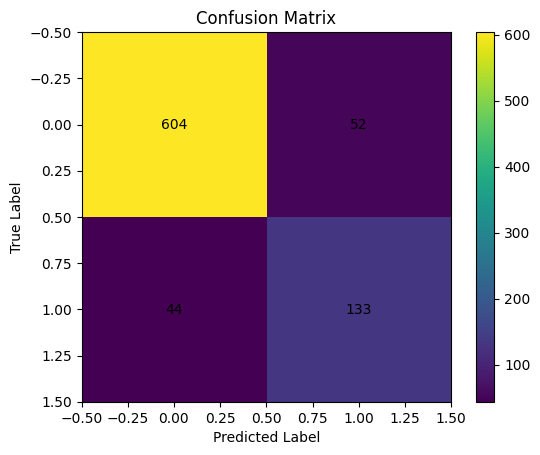

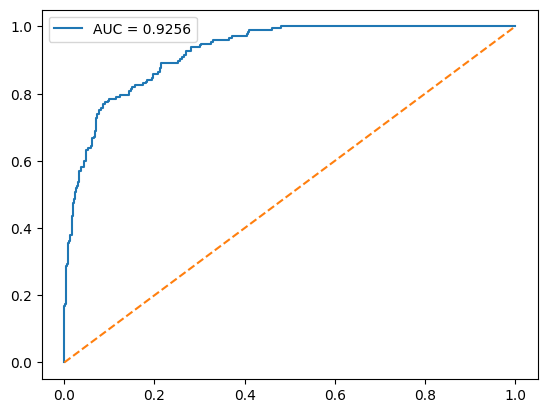

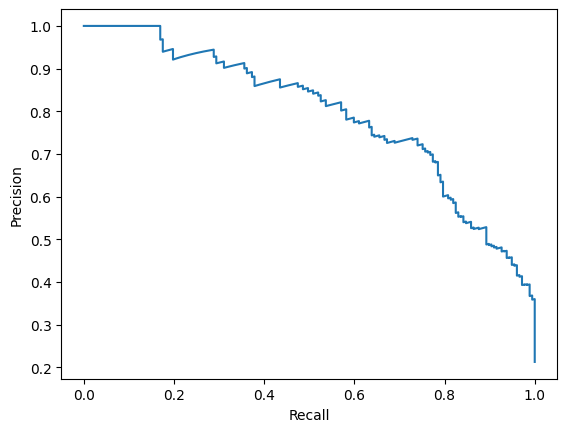

In [19]:
evaluate_murmur_model(model, val_dl)

In [44]:
checkpoint_path = "/kaggle/working/hs_murmur_model_v3.pt"

model = MurmurModel().to(device)

model.load_state_dict(
    torch.load(checkpoint_path, map_location=device)
)

model.to(device)
model.eval()

print("Model loaded successfully from:", checkpoint_path)


Model loaded successfully from: /kaggle/working/hs_murmur_model_v3.pt


In [ ]:
evaluate_murmur_model(model, val_dl)